# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [234]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm

In [235]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


## Read data 

In [236]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

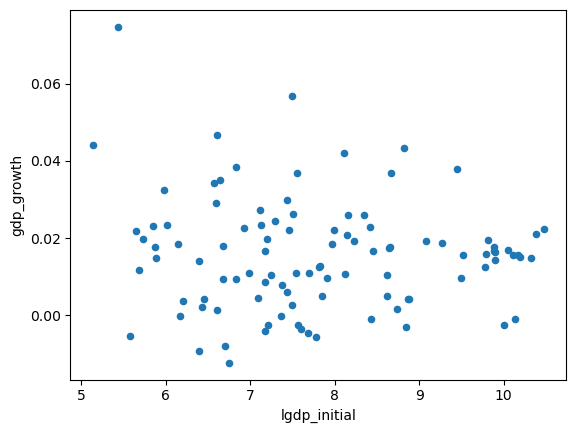

In [237]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth');

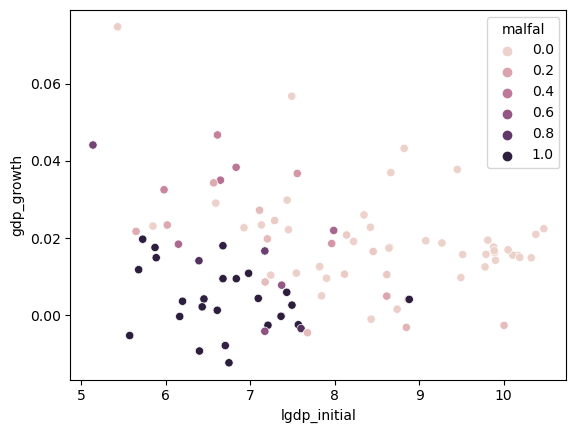

In [238]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [239]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage'] # Diseases
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

# Variables we use
# Institutions, geography, religion, danger (health), resources, education, pop growth

# Code job for Lucas
# Use variables choosen
# Graph Lasso with different penalty levels
# Lasso with CV, BRT and BCCH at difference penalty levels like in week 4 exercise
# Use BRT and BCCH optimal penalty level and use dobbel lasso and post dobbelt lasso.



In [240]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))

# Simple OLS

In [241]:
# 1. avoiding missings 
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)

# 2. extract dataset 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, ['constant','lgdp_initial']].values

# 3. run OLS
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

[[ 2.24792211]
 [-0.08713416]]


# Adding more controls

In [242]:
vs = vv_all['geography'] + vv_all['religion']
xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
X = np.hstack([X, oo])
xs.append('constant') # we put it in as the last element

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X.T @ X) @ X.T @ y
#print(betas)

In [243]:
# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'β': betas[:,0]}, index=xs).round(3)

Mean y =  1.52% growth per year


,β
lgdp_initial,-1.118
pop_growth,6.830
investment_rate,0.068
tropicar,-0.411
distr,-0.000
distcr,0.001
distc,-0.003
suitavg,-1.063
temp,-0.204
suitgini,-0.771


In [244]:
import numpy as np
import pandas as pd
from datetime import datetime

# ---- configuration ----
id_col = 'code'
cols_to_check = ['gdp_growth', 'gdp_pc_initial', 'gdp_pc_now']
continent_cols = ['africa', 'americas', 'asia', 'europe', 'oceania'] # Europa is irrelevant, as it is reference dummy
report_path = 'data_cleaning_report.txt'

# ---- identify rows to remove / keep ----
missing_mask = dat[cols_to_check].isnull().any(axis=1)
removed = dat.loc[missing_mask].copy()
kept = dat.loc[~missing_mask].copy()

# ---- helper: decode continent from dummies ----
def resolve_continent(row):
    active = [c for c in continent_cols if row.get(c, 0) == 1]
    if len(active) == 1:
        return active[0].capitalize()
    elif len(active) == 0:
        return "Unknown"
    else:
        return "Multiple"

removed['continent'] = removed.apply(resolve_continent, axis=1)
kept['continent']   = kept.apply(resolve_continent, axis=1)

# (optional) which GDP columns were missing for removed
removed['missing_in'] = dat.loc[missing_mask, cols_to_check].isnull().apply(
    lambda r: ', '.join([c for c, v in r.items() if v]), axis=1
)

# ---- completeness table for kept countries, for "other variables" ----
exclude = set([id_col] + cols_to_check + continent_cols)
other_vars = [c for c in dat.columns if c not in exclude]

non_missing_counts = kept[other_vars].notnull().sum().rename('non_missing')
missing_counts = (len(kept) - non_missing_counts).rename('missing')
completeness = ((non_missing_counts / len(kept)) * 100).round(1).rename('complete_%')

completeness_table = pd.concat([non_missing_counts, missing_counts, completeness], axis=1)\
                       .sort_index()

# ---- build the report text ----
lines = []
lines.append("DATA CLEANING REPORT")
lines.append(f"Generated: {datetime.now().isoformat(timespec='seconds')}")
lines.append("")
lines.append(f"Total rows before cleaning: {len(dat)}")
lines.append(f"Rows removed (missing in {', '.join(cols_to_check)}): {len(removed)}")
lines.append(f"Rows kept (complete in those columns): {len(kept)}")
lines.append("")

# Removed list
lines.append("=== REMOVED COUNTRIES ===")
if removed.empty:
    lines.append("(none)")
else:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        lines.append(removed[[id_col, 'continent', 'missing_in']].sort_values([ 'continent', id_col]).to_string(index=False))
lines.append("")

# Kept list
lines.append("=== KEPT COUNTRIES ===")
if kept.empty:
    lines.append("(none)")
else:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        lines.append(kept[[id_col, 'continent']].sort_values([ 'continent', id_col]).to_string(index=False))
lines.append("")

# Summary by continent
lines.append("=== SUMMARY BY CONTINENT ===")
summary = pd.DataFrame({
    'removed': removed['continent'].value_counts(),
    'kept': kept['continent'].value_counts()
}).fillna(0).astype(int).sort_index()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    lines.append(summary.to_string())
lines.append("")

# Completeness table
lines.append("=== COMPLETENESS FOR KEPT COUNTRIES (OTHER VARIABLES) ===")
lines.append(f"(Variables excluded from this table: {', '.join(sorted(exclude))})")
if len(other_vars) == 0:
    lines.append("(no other variables found)")
else:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        lines.append(completeness_table.to_string())

# ---- write file ----
with open(report_path, 'w', encoding='utf-8') as f:
    f.write("\n".join(lines))

print(f"Report written to: {report_path}")


Report written to: data_cleaning_report.txt


# Testcode from Week 4 Lasso

In [245]:
# Keep only interesting variables
# Combining all variables we want to use
vs = []
vs.extend(vv_all['institutions'])  # Institutional variables
vs.extend(vv_all['geography'])     # Geographic variables
vs.extend(vv_all['religion'])      # Religious variables
vs.extend(vv_all['danger'])        # Health/disease variables
vs.extend(vv_all['resources'])     # Natural resource variables
vs.extend(vv_educ)                 # Education variables
vs.extend(['pop_growth'])          # Population growth

# Add our main variables of interest
main_vars = ['gdp_growth', 'lgdp_initial', 'constant']
all_vars = main_vars + vs

# Check which variables have missing values before filtering
print("Missing values before filtering:")
print(dat[all_vars].isnull().sum())

# Only remove countries with missing values in our chosen variables
complete_cases = dat[all_vars].notnull().all(axis=1)
kept = dat[complete_cases].copy()

# Verify no missing values remain in our variables of interest
print("\nMissing values after filtering:")
print(kept[all_vars].isnull().sum())


# Prepare data for Lasso
y = kept['gdp_growth'].values.reshape((-1,1)) * 100.0  # Convert to percentage
X = kept[vs + ['lgdp_initial', 'constant']].values     # All variables except the dependent variable
Xnames = kept[vs + ['lgdp_initial', 'constant']].columns

# Print dimensions of our matrices
print(f'X matrix shape: {X.shape}')
print(f'y vector shape: {y.shape}')

Missing values before filtering:
gdp_growth      112
lgdp_initial    105
constant          0
marketref        78
dem              59
demCGV           64
demBMR           60
demreg           31
tropicar         55
distr            55
distcr           55
distc            55
suitavg          59
temp             30
suitgini         54
elevavg          30
elevstd          53
kgatr            54
precip           30
area              6
abslat            9
cenlong           6
area_ar          18
rough            30
landlock         51
africa            6
asia              6
oceania           6
americas          6
pprotest         13
pcatholic        10
pmuslim          10
yellow           51
malfal           50
uvdamage          7
oilres           60
goldm            55
iron             55
silv             55
zinc             55
ls_bl            71
lh_bl            71
pop_growth       16
dtype: int64

Missing values after filtering:
gdp_growth      0
lgdp_initial    0
constant        0
marketr

# Check rank and collinearity

In [246]:
# Check matrix rank
print(f"Matrix X shape: {X.shape}")
print(f"Matrix rank: {np.linalg.matrix_rank(X)}")
print(f"Full rank would be: {X.shape[1]}")

# Create correlation matrix
variable_names = vs + ['lgdp_initial', 'constant']
corr_matrix = pd.DataFrame(X, columns=variable_names).corr()

# Find highly correlated pairs
threshold = 0.95  # You can adjust this threshold
high_corr = np.where(np.abs(corr_matrix) > threshold)
high_corr_pairs = [(variable_names[i], variable_names[j], corr_matrix.iloc[i,j])
                   for i, j in zip(*high_corr) 
                   if i < j]  # avoid duplicate pairs and self-correlations

print("\nHighly correlated variable pairs (correlation > 0.95):")
for var1, var2, corr in high_corr_pairs:
    print(f"{var1} - {var2}: {corr:.3f}")

# Check condition number (high values indicate collinearity)
condition_number = np.linalg.cond(X)
print(f"\nCondition number: {condition_number:.2e}")
if condition_number > 1e4:
    print("Warning: High condition number indicates strong multicollinearity")

# Compute VIF for each variable (excluding constant)
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_no_const = X[:, :-1]  # Remove constant column for VIF calculation
vif_data = pd.DataFrame()
vif_data["Variable"] = variable_names[:-1]  # Exclude constant
vif_data["VIF"] = [variance_inflation_factor(X_no_const, i) for i in range(X_no_const.shape[1])]

print("\nVariance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False))

Matrix X shape: (72, 42)
Matrix rank: 41
Full rank would be: 42

Highly correlated variable pairs (correlation > 0.95):
demCGV - demBMR: 1.000
abslat - uvdamage: -0.954

Condition number: 6.11e+16

Variance Inflation Factors:
        Variable          VIF
2         demCGV          inf
3         demBMR          inf
31      uvdamage  1214.091777
10          temp   628.271566
40  lgdp_initial   208.075248
11      suitgini    76.310645
12       elevavg    65.090154
22        africa    64.030285
8          distc    58.636483
17        abslat    57.946948
5       tropicar    55.308882
9        suitavg    53.613272
25      americas    53.554306
23          asia    49.607923
39    pop_growth    47.789734
18       cenlong    47.453321
24       oceania    39.611128
34          iron    38.688022
13       elevstd    37.019515
19       area_ar    36.380515
15        precip    34.037125
7         distcr    33.207964
6          distr    30.582843
36          zinc    24.238392
20         rough    20.7

d:\Users\lucas\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


# Remove perfect multicollinearity

In [247]:
# Function to remove perfect multicollinearity
def remove_multicollinearity(X, variable_names, threshold=1.0):
    # Convert to DataFrame for easier handling
    X_df = pd.DataFrame(X, columns=variable_names)
    
    # Find correlation matrix
    corr_matrix = X_df.corr()
    
    # Keep track of columns to drop
    to_drop = set()
    
    # Find perfectly correlated pairs
    for i in range(len(variable_names)):
        for j in range(i+1, len(variable_names)):
            if abs(corr_matrix.iloc[i,j]) >= threshold:
                # Keep the first variable, drop the second
                to_drop.add(variable_names[j])
                print(f"Dropping {variable_names[j]} due to correlation with {variable_names[i]}")
    
    # Store constant column if it exists
    has_constant = 'constant' in X_df.columns
    if has_constant:
        constant_col = X_df['constant']
        X_no_const = X_df.drop('constant', axis=1)
    else:
        X_no_const = X_df
    
    # Check for linear dependencies
    # Convert to numpy array for numerical stability
    X_array = X_no_const.values
    try:
        # Use SVD to check for linear dependencies
        u, s, vh = np.linalg.svd(X_array)
        rank = np.sum(s > 1e-10)
        
        # If rank is less than number of columns, we have linear dependencies
        if rank < X_array.shape[1]:
            # Use correlation to identify which columns to drop
            for i in range(X_array.shape[1]):
                if i not in to_drop:  # Skip if already marked for dropping
                    col_i = X_array[:, i]
                    # Try to predict column i from other columns
                    other_cols = [j for j in range(X_array.shape[1]) if j != i and j not in to_drop]
                    if other_cols:  # If there are other columns to check
                        X_others = X_array[:, other_cols]
                        try:
                            beta = np.linalg.lstsq(X_others, col_i, rcond=None)[0]
                            pred = X_others @ beta
                            if np.allclose(col_i, pred, rtol=1e-10, atol=1e-10):
                                to_drop.add(X_no_const.columns[i])
                                print(f"Dropping {X_no_const.columns[i]} due to linear dependency")
                        except np.linalg.LinAlgError:
                            continue
    except np.linalg.LinAlgError:
        print("Warning: SVD decomposition failed, skipping linear dependency check")
    
    # Drop the identified columns
    X_cleaned = X_df.drop(columns=list(to_drop))
    
    # Add back constant if it was present
    if has_constant:
        X_cleaned['constant'] = constant_col
    
    return X_cleaned.values, X_cleaned.columns.tolist(), list(to_drop)

# Apply the multicollinearity removal
print("Starting multicollinearity check...")
X_cleaned, remaining_vars, dropped_vars = remove_multicollinearity(X, variable_names)

print("\nShape before cleaning:", X.shape)
print("Shape after cleaning:", X_cleaned.shape)
print("\nDropped variables:", dropped_vars)

# Verify the rank of cleaned data
print("\nRank check after cleaning:")
print(f"Matrix rank: {np.linalg.matrix_rank(X_cleaned)}")
print(f"Full rank would be: {X_cleaned.shape[1]}")

# Update X and variable_names for subsequent analysis
X = X_cleaned
variable_names = remaining_vars

# Recompute VIF for remaining variables (excluding constant)
print("\nComputing VIF for remaining variables...")
if 'constant' in variable_names:
    X_no_const = X[:, :-1]
    vars_no_const = [v for v in variable_names if v != 'constant']
else:
    X_no_const = X
    vars_no_const = variable_names

vif_data = pd.DataFrame()
vif_data["Variable"] = vars_no_const
vif_data["VIF"] = [variance_inflation_factor(X_no_const, i) for i in range(X_no_const.shape[1])]

print("\nUpdated Variance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False))

Starting multicollinearity check...
Dropping demBMR due to correlation with demCGV

Shape before cleaning: (72, 42)
Shape after cleaning: (72, 41)

Dropped variables: ['demBMR']

Rank check after cleaning:
Matrix rank: 41
Full rank would be: 41

Computing VIF for remaining variables...

Updated Variance Inflation Factors:
        Variable          VIF
30      uvdamage  1214.091777
9           temp   628.271566
39  lgdp_initial   208.075248
10      suitgini    76.310645
11       elevavg    65.090154
21        africa    64.030285
7          distc    58.636483
16        abslat    57.946948
4       tropicar    55.308882
8        suitavg    53.613272
24      americas    53.554306
22          asia    49.607923
38    pop_growth    47.789734
17       cenlong    47.453321
23       oceania    39.611128
33          iron    38.688022
12       elevstd    37.019515
18       area_ar    36.380515
14        precip    34.037125
6         distcr    33.207964
5          distr    30.582843
35          zinc

# Standarize all the variables

In [248]:
def standardize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    X_tilde = (X - mu)/sigma
    return X_tilde

# Standardize X, excluding the constant column if it exists
if 'constant' in variable_names:
    # Find the index of the constant column
    const_idx = variable_names.index('constant')
    # Standardize all columns except the constant
    X_no_const = np.delete(X, const_idx, axis=1)
    X_std = standardize(X_no_const)
    # Add back the constant column
    X_tilde = np.column_stack([X_std, X[:, const_idx]])
else:
    X_tilde = standardize(X)

print("Shape of standardized X:", X_tilde.shape)

Shape of standardized X: (72, 41)


In [254]:
# Create a grid using numpy.geomspace
penalty_grid = np.geomspace(0.01, 80000, num = 500)

coefs=[]
for lamb in penalty_grid:
    fit = Lasso(alpha = lamb).fit(X_tilde,y) 
    coefs.append(fit.coef_) # Note how we extract the coefficients from fit and append them to coefs

In [264]:
def plot_lasso_path(penalty_grid, coefs, legends=None, vlines: dict = None):
    """
    Plots the coefficients as a function of the penalty parameter for Lasso regression.

    Behaviors changed: sets maximum displayed penalty to 1e1 and omits the variable-name legend.
    """
    # Create figure with specific size
    plt.figure(figsize=(8, 5))

    # Ensure coefficients are a numpy array of shape (n_penalties, n_vars)
    coefs_array = np.array(coefs)
    if coefs_array.ndim == 1:
        coefs_array = coefs_array.reshape(-1, 1)

    # Plot each coefficient path (no legend to avoid clutter)
    for j in range(coefs_array.shape[1]):
        plt.plot(penalty_grid, coefs_array[:, j], linewidth=1)

    # Log scale for x-axis
    plt.xscale('log')

    # Set x-axis limits: min penalty to 1e1
    xmin = float(np.min(penalty_grid))
    xmax = 1e0
    plt.xlim(left=xmin, right=xmax)

    # Labels and title (use proper TeX strings)
    plt.xlabel(r"Penalty, $\lambda$")
    plt.ylabel(r"Estimates, $\widehat{\beta}_j(\lambda)$")
    plt.title('Lasso Path for selected variables')

    # Add vertical lines if specified (still shown)
    if vlines is not None:
        for name, penalty in vlines.items():
            if penalty <= xmax:
                plt.axvline(x=penalty, linestyle='--', color='grey', alpha=0.6)
                plt.text(penalty,-80000,name,rotation=90)

    # Make layout compact
    plt.tight_layout()

    # Show plot
    plt.show()
    plt.close()

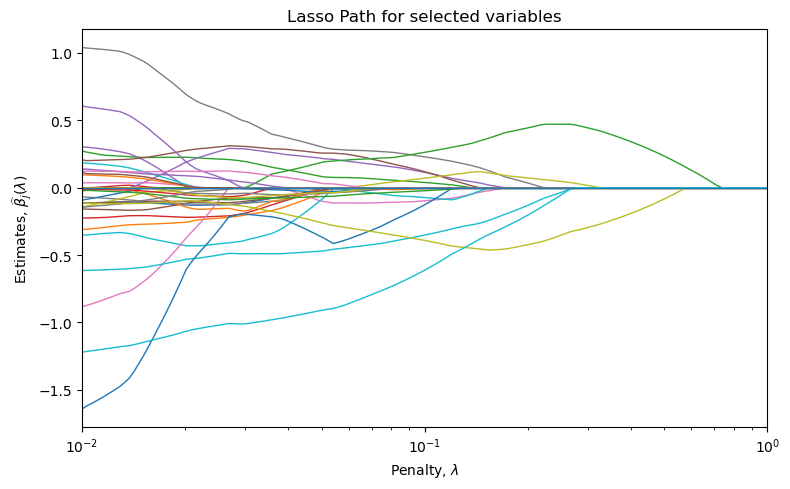

In [265]:
# Plot lasso path
plot_lasso_path(penalty_grid, coefs, Xnames)

In [266]:
# Convert coefficients to array
coefs_array = np.array(coefs)
if coefs_array.ndim == 1:
    coefs_array = coefs_array.reshape(-1, 1)

n_lams, n_vars = coefs_array.shape

# Determine variable names (prefer variable_names, then Xnames)
try:
    names = list(variable_names)
except NameError:
    try:
        names = list(Xnames)
    except NameError:
        names = [f'var_{i}' for i in range(n_vars)]

# Safety: if names length mismatches, generate generic names
if len(names) != n_vars:
    names = [f'var_{i}' for i in range(n_vars)]

tol = 1e-8
persistence = np.zeros(n_vars)
for j in range(n_vars):
    idx = np.where(np.abs(coefs_array[:, j]) > tol)[0]
    if idx.size == 0:
        persistence[j] = 0.0
    else:
        persistence[j] = float(np.max(penalty_grid[idx]))

# Exclude constant from ranking if present
const_idx = None
if 'constant' in names:
    const_idx = names.index('constant')

items = [(names[j], persistence[j]) for j in range(n_vars) if j != const_idx]
items_sorted = sorted(items, key=lambda x: x[1], reverse=True)

topk = 10
print(f"Top {topk} variables by maximum penalty where they remain non-zero (lambda_max):\n")
for name, lam in items_sorted[:topk]:
    print(f"{name:25s}  lambda_max = {lam:.3e}")

# Summary
never_selected = [names[j] for j in range(n_vars) if persistence[j] == 0 and j != const_idx]
print(f"\nNumber never selected: {len(never_selected)}")
if len(never_selected) <= 30:
    print("Never selected:", never_selected)
else:
    print("Never selected (first 30):", never_selected[:30])

Top 10 variables by maximum penalty where they remain non-zero (lambda_max):

asia                       lambda_max = 7.141e-01
pop_growth                 lambda_max = 5.713e-01
area_ar                    lambda_max = 3.220e-01
malfal                     lambda_max = 2.746e-01
lgdp_initial               lambda_max = 2.660e-01
cenlong                    lambda_max = 2.197e-01
distcr                     lambda_max = 1.703e-01
precip                     lambda_max = 1.703e-01
temp                       lambda_max = 1.499e-01
area                       lambda_max = 1.407e-01

Number never selected: 2
Never selected: ['elevstd', 'iron']
